# Projet "Capitals Learning"
## Classification d'images de capitales du monde

Groupe : Paul ANACLET, Nicolas CORMARY, Sylvain CROUZET, Théo DESPRATS

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from models.basic_model_1 import basic_model_1
from models.vgg16_model import vgg16_model
from features.load_data import load_data
from features.get_classes import get_classes
from data.dispatch_data import dispatch_data
from visualization.plot_classes_repartition import plot_classes_repartition
from visualization.plot_training_analysis import plot_training_analysis
from visualization.visualize_random_images import visualize_random_images

### Meta-paramètres

In [2]:
EPOCHS = 20
BATCH_SIZE = 10
LEARNING_RATE = 3e-4

## Chargement des données

### Répartition des images

In [3]:
# Répartition des images dans les différents datasets
pourcentageTrain = 70
pourcentageTest = 15
pourcentageValidation = 15

dispatch_data(pourcentageTrain, pourcentageTest, pourcentageValidation)


Images successfully dispatched.


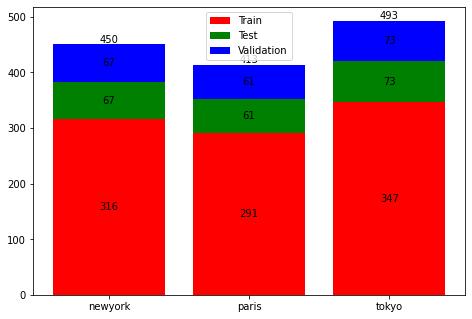

In [4]:
plot_classes_repartition()

### Chargement des images

In [5]:
CLASSES = get_classes()
IMAGE_SIZE = 64

x_train, y_train = load_data(dataset='train', image_size=IMAGE_SIZE)
x_val, y_val = load_data(dataset='validation', image_size=IMAGE_SIZE)
x_test, y_test = load_data(dataset='test', image_size=IMAGE_SIZE)

# Normalisation des entrées via une division par 255 des valeurs de pixel.
x_train = x_train/255
x_val = x_val/255
x_test = x_test/255

### Visualisation des images

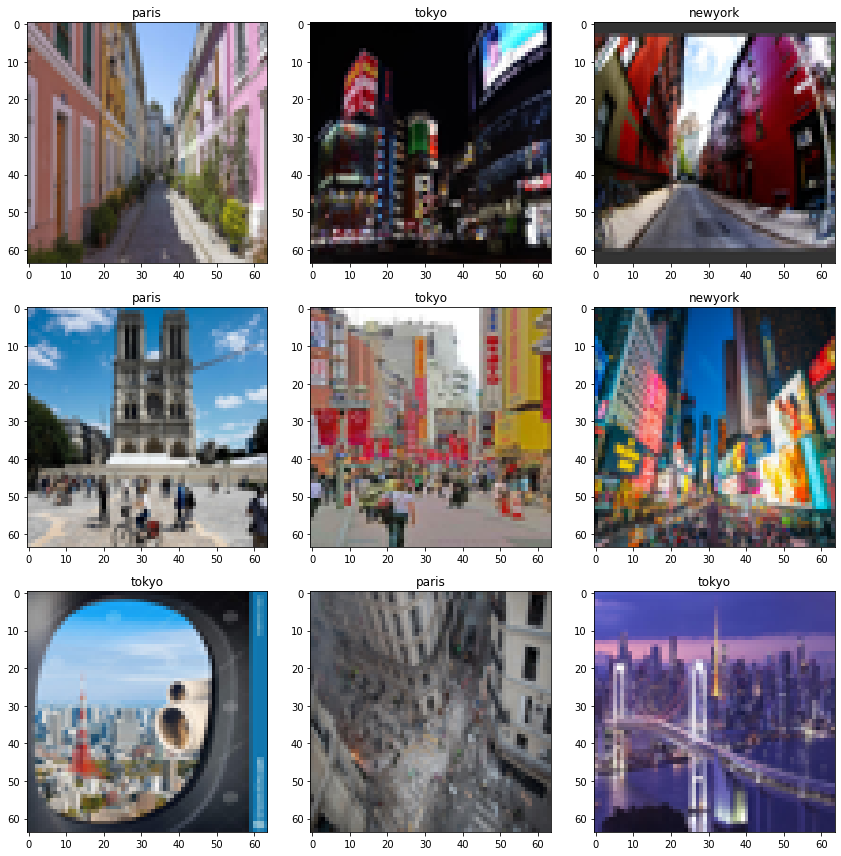

In [6]:
%matplotlib inline

visualize_random_images(x_train, y_train, CLASSES)

### Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True)

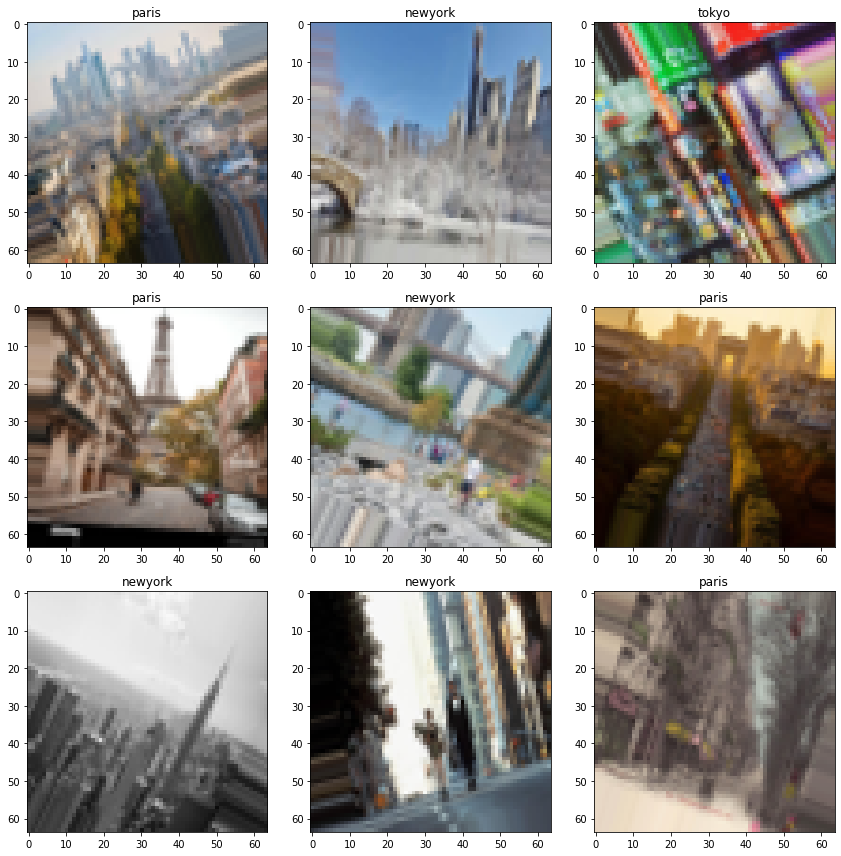

In [8]:
%matplotlib inline

generated = train_datagen.flow(x_train, y_train, batch_size=BATCH_SIZE)
img, label = generated.next()

visualize_random_images(img, label, CLASSES)

## Modèles

### Basic Model 1

[Code source](models/basic_model_1.py)

In [9]:
# Creation du modele
model = basic_model_1(CLASSES, IMAGE_SIZE)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 96)        55392     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 96)         0

In [10]:
# Entrainement du modele
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

history_bm1 = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/20
96/96 [==============================] - 3s 30ms/step - loss: 1.0836 - accuracy: 0.3952 - val_loss: 1.0432 - val_accuracy: 0.4328
Epoch 2/20
96/96 [==============================] - 3s 30ms/step - loss: 1.0374 - accuracy: 0.4392 - val_loss: 1.0091 - val_accuracy: 0.4776
Epoch 3/20
96/96 [==============================] - 3s 29ms/step - loss: 1.0136 - accuracy: 0.4748 - val_loss: 1.0145 - val_accuracy: 0.5025
Epoch 4/20
96/96 [==============================] - 3s 28ms/step - loss: 0.9946 - accuracy: 0.4948 - val_loss: 0.9800 - val_accuracy: 0.4776
Epoch 5/20
96/96 [==============================] - 3s 28ms/step - loss: 0.9508 - accuracy: 0.5419 - val_loss: 0.9659 - val_accuracy: 0.5025
Epoch 6/20
96/96 [==============================] - 3s 30ms/step - loss: 0.9160 - accuracy: 0.5577 - val_loss: 0.9918 - val_accuracy: 0.5224
Epoch 7/20
96/96 [==============================] - 3s 29ms/step - loss: 0.8902 - accuracy: 0.5807 - val_loss: 0.9149 - val_accuracy: 0.5473
Epoch 8/20
96

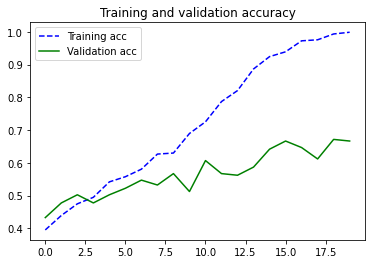

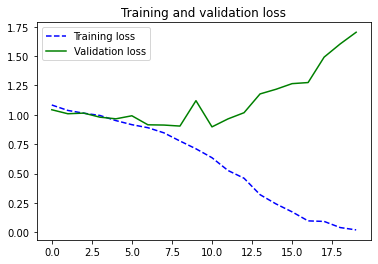

In [14]:
# Analyse des résultats
plot_training_analysis(history_bm1, 'accuracy')

### VGG-16

#### Transfer learning

In [11]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights='imagenet', # On utilise les poids du réseau déjà pré-entrainé sur la base de données ImageNet
                  include_top=False, # On ne conserve pas la partie Dense du réseau originel
                  input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

In [12]:
train_features = conv_base.predict(x_train)
train_features = np.reshape(train_features,(train_features.shape[0],2*2*512))

val_features = conv_base.predict(x_val)
val_features = np.reshape(val_features,(val_features.shape[0],2*2*512))

In [13]:
from keras import models
from keras import layers
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dense(len(CLASSES), activation="softmax"))


model.compile(optimizer=optimizers.Adam(learning_rate=3e-4),
              loss="sparse_categorical_crossentropy",
              metrics=['accuracy'])

model.summary()


history = model.fit(train_features, y_train,
                    epochs=15,
                    batch_size=16,
                    validation_data=(val_features, y_val))

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dense_3 (Dense)             (None, 3)                 771       
                                                                 
Total params: 525,315
Trainable params: 525,315
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
60/60 [==============================] - 1s 5ms/step - loss: 0.9965 - accuracy: 0.5178 - val_loss: 0.8462 - val_accuracy: 0.6219
Epoch 2/15
60/60 [==============================] - 0s 3ms/step - loss: 0.7725 - accuracy: 0.6792 - val_loss: 0.8814 - val_accuracy: 0.6169
Epoch 3/15
60/60 [==============================] - 0s 3ms/step - loss: 0.6410 - accuracy: 0.7474 - val_loss: 0.8102 - val_accuracy: 0.6716
Epoch 4/15
60/60 [======

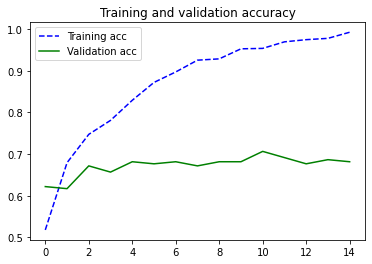

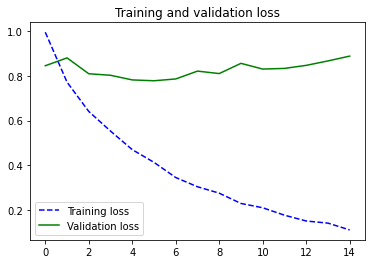

In [15]:
plot_training_analysis(history, 'accuracy')

#### Intégration de l'augmentation de données

In [16]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(Dense(256, activation='relu', input_dim=2*2*512))
model.add(Dense(len(CLASSES), activation="softmax"))


conv_base.trainable = False
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 525,315
Non-trainable params: 14,714,688
_________________________________________________________________


In [17]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=20,
                    )

#Problème pas assez d'époque (10 -> 50) et on avait mis metrics=['accurency']

Epoch 1/20
96/96 [==============================] - 13s 126ms/step - loss: 1.0248 - sparse_categorical_accuracy: 0.4979 - val_loss: 0.8918 - val_sparse_categorical_accuracy: 0.5721
Epoch 2/20
96/96 [==============================] - 11s 117ms/step - loss: 0.8605 - sparse_categorical_accuracy: 0.6331 - val_loss: 0.8652 - val_sparse_categorical_accuracy: 0.5970
Epoch 3/20
96/96 [==============================] - 11s 117ms/step - loss: 0.8027 - sparse_categorical_accuracy: 0.6436 - val_loss: 0.8132 - val_sparse_categorical_accuracy: 0.6567
Epoch 4/20
96/96 [==============================] - 11s 118ms/step - loss: 0.7524 - sparse_categorical_accuracy: 0.6918 - val_loss: 0.8117 - val_sparse_categorical_accuracy: 0.6368
Epoch 5/20
96/96 [==============================] - 11s 116ms/step - loss: 0.7305 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.8161 - val_sparse_categorical_accuracy: 0.6517
Epoch 6/20
96/96 [==============================] - 11s 116ms/step - loss: 0.6997 - sparse_cate

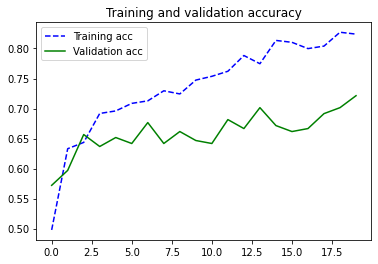

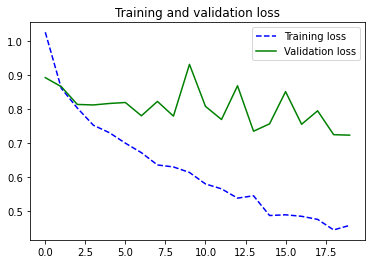

In [18]:
plot_training_analysis(history, 'sparse_categorical_accuracy')

#### Fine-tuning

In [19]:
conv_base.trainable = True
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 256)               524544    
                                                                 
 dense_5 (Dense)             (None, 3)                 771       
                                                                 
Total params: 15,240,003
Trainable params: 15,240,003
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizers.Adam(learning_rate=3e-4),
              metrics=['sparse_categorical_accuracy'])

history = model.fit(train_datagen.flow(x_train, y_train, batch_size=10), 
                    validation_data=(x_val, y_val),
                    epochs=20,
                    )

Epoch 1/20
96/96 [==============================] - 55s 566ms/step - loss: 1.3397 - sparse_categorical_accuracy: 0.3470 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.3632
Epoch 2/20
96/96 [==============================] - 54s 565ms/step - loss: 1.1100 - sparse_categorical_accuracy: 0.3302 - val_loss: 1.1001 - val_sparse_categorical_accuracy: 0.3632
Epoch 3/20
96/96 [==============================] - 54s 561ms/step - loss: 1.1016 - sparse_categorical_accuracy: 0.3480 - val_loss: 1.0974 - val_sparse_categorical_accuracy: 0.3632
Epoch 4/20
96/96 [==============================] - 54s 558ms/step - loss: 1.0973 - sparse_categorical_accuracy: 0.3637 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.3632
Epoch 5/20
96/96 [==============================] - 54s 561ms/step - loss: 1.0969 - sparse_categorical_accuracy: 0.3637 - val_loss: 1.0965 - val_sparse_categorical_accuracy: 0.3632
Epoch 6/20
96/96 [==============================] - 55s 575ms/step - loss: 1.0965 - sparse_cate

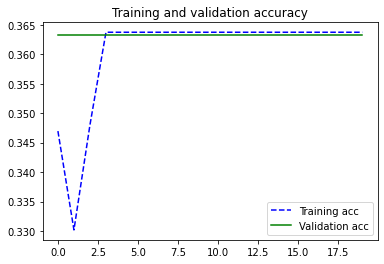

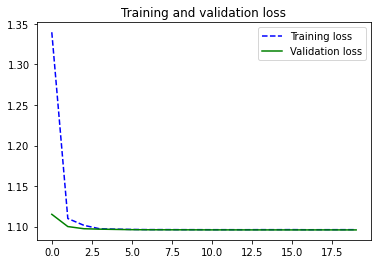

In [21]:
plot_training_analysis(history, 'sparse_categorical_accuracy')

## Analyse

### TODO: Courbes avec toutes les accuracy des modèles